# Fake maps with fake seeing 3dfield

+ Generate simulated emissivity and velocity cubes
+ Integrate them to get simulated intensity, velocity (and sigma) maps
+ Make them non periodic by dividing them in 4.
+ Apply fake seeing to the cubes
+ Export 2x2 moment1 maps: non-tapared, tapered and smoothed tapered


In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path
import numpy as np
import json
import cmasher as cmr
from matplotlib import pyplot as plt
import seaborn as sns
import sys

import turbustat.statistics as tss
import turbustat.simulator
from turbustat.simulator import make_ppv
from spectral_cube import SpectralCube  

from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc

sns.set_color_codes()
sns.set_context("talk")

### Non-periodic boundaries

We can make a map that is twice as big and then analyze 1/4 of it. That way, it will not be periodic.  

In [3]:
widths = [1, 2, 4, 8, 16, 32]
r0 = 32.0
N = 256
m = 0.55

In [4]:
def split_square_in_4(arr):
    ny, nx = arr.shape
    assert nx == ny and nx % 2 == 0
    slices = slice(None, nx // 2), slice(nx // 2, None)
    corners = []
    for i, j in [
        (0, 0),
        (0, 1),
        (1, 0),
        (1, 1),
    ]:
        corners.append(arr[slices[i], slices[j]])
    return corners




#### Effects of smoothing the non-periodic maps

In [5]:
## Emissivity fluctuations

density = make_3dfield(2*N, 
                       powerlaw=3.0 + m, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=328764) * u.cm**-3  

density = (density-density.mean())/density.std()

sig_E = 2
emissivity = np.exp(sig_E * density)* u.cm**-3

non-tapered

In [6]:
v_nt = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  



cube_hdu_nt = make_ppv(v_nt, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.25 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube_nt = SpectralCube.read(cube_hdu_nt)  

vms_nt = split_square_in_4(cube_nt.moment1().value)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [7]:
cube_nt.write('cube_fits//cube_nt_ems_fluct_s0_np.fits', format='fits')  

Tapared maps

In [8]:
velocity = make_3dfield(
    2*N,
    ellip=0.5,
    theta=45,
    correlation_length=r0,  
    powerlaw=3.0 + m,
    randomseed=2021_10_08)* u.km / u.s  



cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.25 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

cube = SpectralCube.read(cube_hdu)  

vms_t = split_square_in_4(cube.moment1().value)

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)


In [9]:
cube.write('cube_fits//cube_ems_fluct_s0_np.fits', format='fits')  

In [10]:
widths = [1, 2, 4, 8, 16, 32]
cubes_smooth = {}
for width in widths:
    kernel = Gaussian2DKernel(x_stddev=width)
    cubes_smooth[width] = cube.spatial_smooth(kernel, boundary="wrap")
    

In [11]:
vmap_nps = {}

for width in widths:
    vmap_nps[width] = split_square_in_4(cubes_smooth[width].moment1().value)
    

In [12]:
v_maps_3ds = {}
v_maps_3ds[0] = vms_nt
v_maps_3ds[1] = vms_t
v_maps_3ds[2] = vmap_nps

In [13]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [14]:
jsonfilename = "vmaps_3d_s0_np_ems_fluct.json"
with open(jsonfilename, "w") as f:
    json.dump(v_maps_3ds, fp=f, indent=3, cls=MyEncoder)

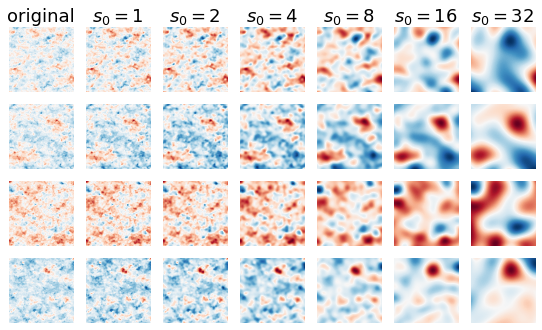

In [15]:
imshow_kwds = dict(origin="lower", cmap="RdBu_r")


ncols = len(widths) + 1
nrows = 4
fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(8, 5.1),
    sharex=True,
    sharey=True,
)
for j, vm in enumerate(vms_t):
    im = axes[j, 0].imshow(vm, **imshow_kwds)
axes[0, 0].set_title("original")
for i, width in enumerate(widths):
    for j, vm in enumerate(vmap_nps[width]):
        im = axes[j, i + 1].imshow(vm, **imshow_kwds)
    axes[0, i + 1].set_title(fr"$s_0 = {width}$")

for ax in axes.flat:
    ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)
fig.tight_layout(h_pad=0.2, w_pad=0.2)
fig.savefig("fake-3d-seeing-nonp-ems-fluct-thumbnails.pdf")

In [16]:
!jupyter nbconvert --to script --no-prompt create-fake-3d-maps-seeing-nonp-ems-fluct.ipynb

[NbConvertApp] Converting notebook create-fake-3d-maps-seeing-nonp-ems-fluct.ipynb to script
[NbConvertApp] Writing 4868 bytes to create-fake-3d-maps-seeing-nonp-ems-fluct.py


In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 6701.075135946274 seconds ---
